정확도는 다음과 같이 계산됩니다:

- 전체 샘플 중에서 **정답(실제 레이블)과 예측이 일치한 샘플의 비율**입니다.
- 수식으로 표현하면:
  - $\text{Accuracy} = \frac{\text{맞게 분류된 샘플 수}}{\text{전체 샘플 수}}$


여기서  
- `correct`: 맞게 분류된 샘플 개수  
- `total`: 전체 샘플 개수

즉, **acc는 전체 데이터 중에서 맞게 분류된 비율(0~1, 또는 0~100%)**을 의미합니다.

In [1]:
# coalb 에서는 두번 실행 해야 합니다.
# 첫 번째 실행 - 폰트 설치 후 자동 재시작
# 두번째 실행 - 폰트 설치 완료
# https://github.com/c0z0c/jupyter_hangul
# 코딩 중간에 한글 깨진다 싶으면 helper.setup() 다시 호출 해줘도 됩니다.

from urllib.request import urlretrieve
urlretrieve("https://raw.githubusercontent.com/c0z0c/jupyter_hangul/master/helper_c0z0c_dev.py", "helper_c0z0c_dev.py")
import helper_c0z0c_dev as helper
print("📁 helper 모듈을 로드했습니다.")
helper.setup()

🚀 Jupyter/Colab 한글 환경 설정 중... (helper v2.3.0)
✅ matplotlib 한글 폰트 설정 완료
✅ 한글 폰트 및 pandas 확장 기능 설정 완료
🎉 사용 가능: 한글 폰트, CSV 읽기, DataFrame.head_att(), 캐시 기능
📁 helper 모듈을 로드했습니다.
🚀 Jupyter/Colab 한글 환경 설정 중... (helper v2.3.0)
✅ matplotlib 한글 폰트 설정 완료
✅ 한글 폰트 및 pandas 확장 기능 설정 완료
🎉 사용 가능: 한글 폰트, CSV 읽기, DataFrame.head_att(), 캐시 기능


# >기본< 라이브리 로드

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import (
    fetch_california_housing, load_iris, make_moons, make_circles,
    load_breast_cancer, load_wine
)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

# --- 다중공선성 진단용 (선택적) ---
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print("statsmodels 라이브러리 로드 완료")
except Exception:
    print("statsmodels 라이브러리가 설치되어 있지 않습니다. 설치: !pip install statsmodels")

# --- 표준 라이브러리 및 유틸리티 ---
import io
import os
import gc
import json
import time
import random
import math
from datetime import datetime, timedelta
import pytz  # 시간대 처리

# --- 이미지 처리 ---
from PIL import Image, ImageDraw, ImageFilter
import cv2  # 필요시 설치: !pip install opencv-python

# --- 데이터/시각화 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from IPython.display import display, Markdown
#from tqdm.auto import tqdm
from tqdm.notebook import tqdm

# --- PyTorch 관련 ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader, random_split

# --- 선택 패키지(주석) ---
# !pip install pytorch-msssim

# --- 시드 고정 ---
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# --- 디바이스 및 전역 설정 ---
__kst = pytz.timezone('Asia/Seoul')
global __kst
__device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global __device
print('Device:', __device)

__model_class_list = []
global __model_class_list
# ...existing code...

# >기본< 모델링 함수

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as v2
from torchvision import models
import matplotlib.pyplot as plt
import time
import copy
from collections import defaultdict
import numpy as np
from tqdm import tqdm

In [ ]:

DEBUG_ON = True if not helper.is_colab else False
print(f"사용 디바이스: {__device}")
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


사용 디바이스: cpu


In [ ]:

# 데이터 전처리 및 증강
def get_data_transforms():
    # 훈련용 데이터 전처리 (데이터 증강 포함)
    train_transform = v2.Compose([
        v2.Resize((224, 224)),  # AlexNet 입력 크기에 맞게 리사이즈
        v2.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 반전
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])  # ImageNet 평균/표준편차
    ])

    # 검증/테스트용 데이터 전처리
    val_transform = v2.Compose([
        v2.Resize((224, 224)),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform


Files already downloaded and verified
훈련 데이터: 50000개
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 32, 32, 3)
120.70756512369792
64.1500758911213
이미지 타입: <class 'PIL.Image.Image'>
이미지 크기: (32, 32)
레이블: 6
클래스명: frog


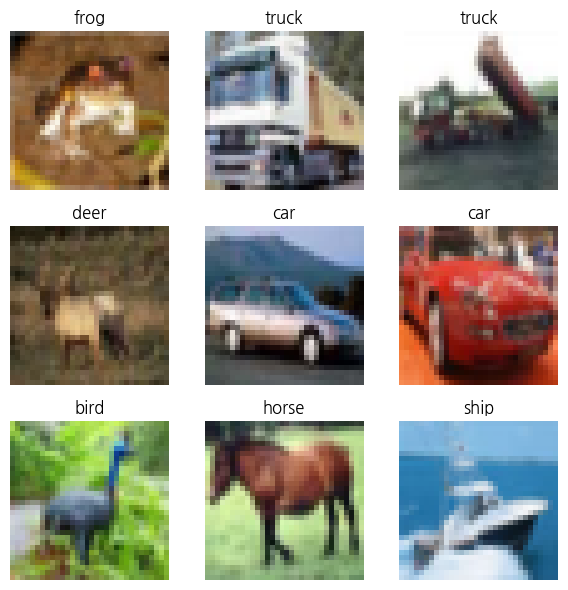

In [ ]:
def show_images(dataset, index=0, num_rows=1, num_cols=3):
    plt.figure(figsize=(2 * num_cols, 2 * num_rows))
    for i in range(num_rows * num_cols):
        img, label = dataset[index + i]  # img: PIL.Image
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def info_data():
    train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    print(f"훈련 데이터: {len(train_data)}개")
    
    print(train_data.classes)
    print(train_data.data.shape)
    print(train_data.data.mean())
    print(train_data.data.std())

    img, label = train_data[0]
    print(f"이미지 타입: {type(img)}")
    print(f"이미지 크기: {img.size}")  # PIL.Image의 size 속성 (width, height)
    print(f"레이블: {label}")
    print(f"클래스명: {classes[label]}")    

    show_images(train_data, 0, 3, 3)
    
info_data()



In [ ]:

# 데이터셋 로드
def load_data():
    train_transform, val_transform = get_data_transforms() # 전처리

    # CIFAR-10 데이터셋 다운로드 및 로드
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform)

    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=val_transform)

    # 검증 세트 생성 (훈련 데이터의 20% 사용)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size])

    # 검증 데이터셋에 올바른 transform 적용
    val_dataset.dataset = copy.deepcopy(train_dataset.dataset)
    val_dataset.dataset.transform = val_transform

    # DEBUG_ON이 True면 3개만 사용
    if DEBUG_ON:
        from torch.utils.data import Subset
        train_dataset = Subset(train_dataset, range(100))
        val_dataset = Subset(val_dataset, range(100))
        test_dataset = Subset(test_dataset, range(100))
        batch_size = 32
    else:
        batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2)

    print(f"훈련 데이터: {len(train_dataset)}개")
    print(f"검증 데이터: {len(val_dataset)}개")
    print(f"테스트 데이터: {len(test_dataset)}개")

    return train_loader, val_loader, test_loader

# load_data()

In [ ]:
# 훈련 함수
def train_fn(model, train_loader, criterion, optimizer, device, epoch=None, epochs=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    res = {}
    desc = f"Train [{epoch+1}/{epochs}]" if epoch is not None and epochs is not None else "Train"
    tqdm_kwargs = {} 
    if DEBUG_ON:
        tqdm_kwargs['disable'] = False
        tqdm_kwargs['mininterval'] = 1
    else:
        tqdm_kwargs['disable'] = True
        tqdm_kwargs['mininterval'] = 3

    pbar = tqdm(train_loader, leave=True, desc=desc, position=0, **tqdm_kwargs)
    
    # tqdm_kwargs = {
    #     'disable': False,  # 항상 표시
    #     'mininterval': 0.5,
    #     'leave': True,
    #     'desc': desc,
    #     'position': 1
    # }
    # pbar = tqdm(train_loader, **tqdm_kwargs)
        
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        # criterion이 기본(reduction='mean')이라 가정하여 샘플 기준 누적
        running_loss += loss.item() * batch_size
        _, predicted = torch.max(outputs, 1)
        total += batch_size
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total if total > 0 else 0.0
    epoch_acc = correct / total if total > 0 else 0.0
    res['loss'] = epoch_loss
    res['acc'] = epoch_acc
    return res

# 검증 함수
def evaluate_fn(model, val_loader, criterion, device, epoch, epochs):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    res = {}
    desc = f"Val   [{epoch+1}/{epochs}]"

    tqdm_kwargs = {} 
    if DEBUG_ON:
        tqdm_kwargs['disable'] = False
        tqdm_kwargs['mininterval'] = 1
    else:
        tqdm_kwargs['disable'] = True
        tqdm_kwargs['mininterval'] = 3


    with torch.no_grad():
        pbar = tqdm(val_loader, leave=True, desc=desc, position=0, **tqdm_kwargs)
        
        # tqdm_kwargs = {
        #     'disable': False,  # 항상 표시
        #     'mininterval': 0.5,
        #     'leave': True,
        #     'desc': desc,
        #     'position': 1
        # }
        # pbar = tqdm(val_loader, **tqdm_kwargs)        
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs, 1)
            total += batch_size
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total if total > 0 else 0.0
    epoch_acc = correct / total if total > 0 else 0.0
    res['loss'] = epoch_loss
    res['acc'] = epoch_acc
    return res

# 모델링 함수 (훈련 + 검증)
def modeling_fn(model, epochs, train_loader, val_loader, criterion, optimizer, scheduler, device):
    import sys
    history = []
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
 
    start_time = time.time()
    epoch_start_time = None

    estimated_completion_str = None
    
    tqdm_kwargs = {} 
    if DEBUG_ON:
        tqdm_kwargs['disable'] = False
        tqdm_kwargs['mininterval'] = 2
    else:
        tqdm_kwargs['disable'] = True
        tqdm_kwargs['mininterval'] = 6

    epoch = 0
    desc = f"Epoch [{epoch+1}/{epochs}]"
    pbar = tqdm(range(epochs), leave=True, desc=desc, position=0, **tqdm_kwargs)
    
    for epoch in pbar:
        sys.stdout.flush()  # 출력 버퍼 비우기
        epoch_start_time = time.time()
        pbar.set_description(f"Epoch [{epoch+1}/{epochs}]")
        
        train_res = train_fn(model, train_loader, criterion, optimizer, device, epoch=epoch, epochs=epochs)
        val_res = evaluate_fn(model, val_loader, criterion, device, epoch=epoch, epochs=epochs)
        if estimated_completion_str is not None:
            pbar.set_postfix_str("종료 " + estimated_completion_str)
            
        # 스케줄러 업데이트
        if scheduler:
            scheduler.step()

        res = {
            "epoch": epoch,
            "epochs": epochs,
            "train": train_res,
            "val": val_res,
        }

        history.append(res)

        # 최고 성능 모델 저장
        if val_res['acc'] > best_val_acc:
            best_val_acc = val_res['acc']
            best_model_wts = copy.deepcopy(model.state_dict())

        # 에포크 완료 시간 계산
        epoch_elapsed = time.time() - epoch_start_time

        # 첫 번째 에포크 완료 후 예상 완료 시간 계산
        if epoch == 0 and epochs > 1:
            remaining_epochs = epochs - 1
            estimated_total_time = epoch_elapsed * epochs
            estimated_completion = datetime.now(__kst) + timedelta(seconds=epoch_elapsed * remaining_epochs)
            estimated_completion_str = estimated_completion.strftime('%Y-%m-%d %H:%M:%S KST')
            pbar.set_postfix_str("종료 " + estimated_completion_str)
            # print(f"첫 에포크 완료 - 예상 완료 시간: {estimated_completion_str}")
            
        
        # print(f"Epoch {epoch+1}/{epochs} - "
        #       f"Train Loss: {train_res['loss']:.4f}, "
        #       f"Train Acc: {train_res['acc']:.4f} | "
        #       f"Val Loss: {val_res['loss']:.4f}, "
        #       f"Val Acc: {val_res['acc']:.4f} "
        #       f"({epoch_elapsed:.1f}s)")

    # 전체 학습 완료 시간
    total_elapsed = time.time() - start_time
    completion_time = datetime.now(__kst)

    # 최고 성능 모델 가중치 로드
    model.load_state_dict(best_model_wts)
    # print(f'\n최고 검증 정확도: {best_val_acc:.4f}')
    # print(f'전체 학습 시간: {total_elapsed:.1f}초 ({total_elapsed/60:.1f}분)')
    # print(f'학습 완료 시간: {completion_time.strftime("%Y-%m-%d %H:%M:%S KST")}')

    return model, history, completion_time, total_elapsed

# 테스트 함수
def test_model(model, test_loader, device):
    """모델 테스트"""
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        pbar = tqdm(test_loader, leave=True, desc="Testing", position=0)
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 클래스별 정확도 계산
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    accuracy = 100 * correct / total
    # print(f'전체 테스트 정확도: {accuracy:.2f}%')

    # # 클래스별 정확도 출력
    # print('\n클래스별 정확도:')
    # for i in range(10):
    #     if class_total[i] > 0:
    #         print(f'{classes[i]:>8}: {100 * class_correct[i] / class_total[i]:.1f}%')

    return accuracy, class_total, classes, class_correct


# 1. From Scratch: 처음부터 완전 새로 학습

In [ ]:
def From_Scratch():
    train_loader, val_loader, test_loader = load_data()
    # 모델 생성
    # weights=None 처음 부터
    model = models.alexnet(weights=None, progress=True)
    # 손실 함수와 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    # # 모델 학습
    model, history, completion_time, total_elapsed = modeling_fn(model, 5, train_loader, val_loader, criterion, optimizer, scheduler, __device)
    best = max(history, key=lambda x: x['val']['acc'])

    test_acc, test_class_total, test_classes, test_class_correct = test_model(model, test_loader, __device)

    res = {
        "name": "From_Scratch",
        "model": model,
        "history": history,
        "completion_time": completion_time,
        "total_elapsed": total_elapsed,
        "best": best,
        "test_acc": test_acc,
        "test_class_total": test_class_total,
        "test_classes": test_classes,
        "test_class_correct": test_class_correct
    }   
    return res

# history, best, test_acc = From_Scratch()


# 2. Feature Extraction: 사전 훈련된 모델의 특성 추출기만 사용

In [ ]:
def Feature_Extraction():
    train_loader, val_loader, test_loader = load_data()
    # num_classes 지정하지 않음
    model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1, progress=True)

    # 모든 파라미터를 고정(특성 추출기만 사용)
    # for param in model.features.parameters():
    #     param.requires_grad = False
    # # 마지막 분류 레이어를 CIFAR-10에 맞게 교체
    # model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
    model = model.to(__device)
    # 손실 함수와 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=1e-4)
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    model, history, completion_time, total_elapsed = modeling_fn(model, 3, train_loader, val_loader, criterion, optimizer, scheduler, __device)
    best = max(history, key=lambda x: x['val']['acc'])

    test_acc, test_class_total, test_classes, test_class_correct = test_model(model, test_loader, __device)
    
    res = {
        "name": "Feature_Extraction",
        "model": model,
        "history": history,
        "completion_time": completion_time,
        "total_elapsed": total_elapsed,
        "best": best,
        "test_acc": test_acc,
        "test_class_total": test_class_total,
        "test_classes": test_classes,
        "test_class_correct": test_class_correct
    }    
    return res
    


# 3. Fine-tuning: 사전 훈련된 모델 전체를 미세조정

In [ ]:
def Fine_tuning():
    train_loader, val_loader, test_loader = load_data()
    # 먼저 사전 훈련된 모델을 1000 클래스로 로드
    model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1, progress=True)
    
    # 마지막 분류 레이어를 CIFAR-10에 맞게 교체 (1000 -> 10)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
    model = model.to(__device)
    
    # 손실 함수와 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    # 모델 학습
    model, history, completion_time, total_elapsed = modeling_fn(model, 1, train_loader, val_loader, criterion, optimizer, scheduler, __device)
    best = max(history, key=lambda x: x['val']['acc'])

    test_acc, test_class_total, test_classes, test_class_correct = test_model(model, test_loader, __device)

    res = {
        "name": "Fine_tuning",
        "model": model,
        "history": history,
        "completion_time": completion_time,
        "total_elapsed": total_elapsed,
        "best": best,
        "test_acc": test_acc,
        "test_class_total": test_class_total,
        "test_classes": test_classes,
        "test_class_correct": test_class_correct
    }   
    return res

# history, best, test_acc = Fine_tuning()

# 모델링 시작

In [ ]:
test_history={}

In [ ]:
# 1. From Scratch: 처음부터 완전 새로 학습
# res = Feature_Extraction()
# res = Fine_tuning()
res = From_Scratch()

print(res['name'])
print(f'전체 학습 시간: {res["total_elapsed"]:.1f}초 ({res["total_elapsed"]/60:.1f}분)')
print(f'학습 완료 시간: {res["completion_time"].strftime("%Y-%m-%d %H:%M:%S KST")}')
print('클래스별 정확도:')
for i in range(10):
    if res["test_class_total"][i] > 0:
        print(f'{res["test_classes"][i]:>8}: {100 * res["test_class_correct"][i] / res["test_class_total"][i]:.1f}%')
print(f"최고 성능 에포크: {res['best']['epoch']+1}")
print(f"Train Loss: {res['best']['train']['loss']:.4f}, Train Acc: {res['best']['train']['acc']:.4f}")
print(f"Val Loss: {res['best']['val']['loss']:.4f}, Val Acc: {res['best']['val']['acc']:.4f}")
print(f"테스트 정확도: {res['test_acc']:.4f}")


In [ ]:
# 2. Feature Extraction: 사전 훈련된 모델의 특성 추출기만 사용
res = Feature_Extraction()
# res = Fine_tuning()
# res = From_Scratch()

print(res['name'])
print(f'전체 학습 시간: {res["total_elapsed"]:.1f}초 ({res["total_elapsed"]/60:.1f}분)')
print(f'학습 완료 시간: {res["completion_time"].strftime("%Y-%m-%d %H:%M:%S KST")}')
print('클래스별 정확도:')
for i in range(10):
    if res["test_class_total"][i] > 0:
        print(f'{res["test_classes"][i]:>8}: {100 * res["test_class_correct"][i] / res["test_class_total"][i]:.1f}%')
print(f"최고 성능 에포크: {res['best']['epoch']+1}")
print(f"Train Loss: {res['best']['train']['loss']:.4f}, Train Acc: {res['best']['train']['acc']:.4f}")
print(f"Val Loss: {res['best']['val']['loss']:.4f}, Val Acc: {res['best']['val']['acc']:.4f}")
print(f"테스트 정확도: {res['test_acc']:.4f}")


Files already downloaded and verified
Files already downloaded and verified
훈련 데이터: 100개
검증 데이터: 100개
테스트 데이터: 100개


Testing: 100%|██████████| 4/4 [00:11<00:00,  3.00s/it]

Feature_Extraction
전체 학습 시간: 162.9초 (2.7분)
학습 완료 시간: 2025-08-19 09:25:39 KST
클래스별 정확도:
   plane: 0.0%
     car: 16.7%
    bird: 12.5%
     cat: 50.0%
    deer: 14.3%
     dog: 62.5%
    frog: 50.0%
   horse: 45.5%
    ship: 92.3%
   truck: 63.6%
최고 성능 에포크: 5
Train Loss: 0.7520, Train Acc: 0.7600
Val Loss: 1.3592, Val Acc: 0.5100
테스트 정확도: 45.0000


In [ ]:
# 3. Fine-tuning: 사전 훈련된 모델 전체를 미세조정

# res = Feature_Extraction()
res = Fine_tuning()
# res = From_Scratch()

print(res['name'])
print(f'전체 학습 시간: {res["total_elapsed"]:.1f}초 ({res["total_elapsed"]/60:.1f}분)')
print(f'학습 완료 시간: {res["completion_time"].strftime("%Y-%m-%d %H:%M:%S KST")}')
print('클래스별 정확도:')
for i in range(10):
    if res["test_class_total"][i] > 0:
        print(f'{res["test_classes"][i]:>8}: {100 * res["test_class_correct"][i] / res["test_class_total"][i]:.1f}%')
print(f"최고 성능 에포크: {res['best']['epoch']+1}")
print(f"Train Loss: {res['best']['train']['loss']:.4f}, Train Acc: {res['best']['train']['acc']:.4f}")
print(f"Val Loss: {res['best']['val']['loss']:.4f}, Val Acc: {res['best']['val']['acc']:.4f}")
print(f"테스트 정확도: {res['test_acc']:.4f}")


Files already downloaded and verified
Files already downloaded and verified
훈련 데이터: 100개
검증 데이터: 100개
테스트 데이터: 100개


Train [1/5]:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# res = Feature_Extraction()
# res = Fine_tuning()
res = From_Scratch()

print(res['name'])
print(f'전체 학습 시간: {res["total_elapsed"]:.1f}초 ({res["total_elapsed"]/60:.1f}분)')
print(f'학습 완료 시간: {res["completion_time"].strftime("%Y-%m-%d %H:%M:%S KST")}')
print('클래스별 정확도:')
for i in range(10):
    if res["test_class_total"][i] > 0:
        print(f'{res["test_classes"][i]:>8}: {100 * res["test_class_correct"][i] / res["test_class_total"][i]:.1f}%')
print(f"최고 성능 에포크: {res['best']['epoch']+1}")
print(f"Train Loss: {res['best']['train']['loss']:.4f}, Train Acc: {res['best']['train']['acc']:.4f}")
print(f"Val Loss: {res['best']['val']['loss']:.4f}, Val Acc: {res['best']['val']['acc']:.4f}")
print(f"테스트 정확도: {res['test_acc']:.4f}")


In [ ]:
# 모델 학습
from torchinfo import summary
summary(res['model'], input_size = (1, 3, 224, 224 ))
